In [ ]:
import os
import random
import time
import heapq
import math
import copy
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)
random.seed(42)

# Task 1- Ship Generator

In [ ]:
def ship_generator(D, loop_chance=0.5, seed=None):
  if seed:
    random.seed(seed)

  # blocked = 1, open = 0
  ship = np.ones((D, D), dtype=int)

  # picking a random cell in the start and opening it
  start_x, start_y = random.randint(1, D-2), random.randint(1, D-2)
  ship[start_x, start_y] = 0

  # returns valid neighbors (up, down, left, right)
  def neighbors(x, y):
    dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    return [(x+dx, y+dy) for dx, dy in dirs if 0 <= x+dx < D and 0 <= y+dy < D]

  changed = True
  while changed:
    changed = False
    candidates = []
    for i in range(1, D-1):
      for j in range(1, D-1):
        if ship[i, j] == 1:
          open_neighbors = sum(1 - ship[x, y] for x, y in neighbors(i, j))
          if open_neighbors == 1:
              candidates.append((i, j))

    if candidates:
      x, y = random.choice(candidates)
      ship[x, y] = 0
      changed = True

  # identifying the dead ends
  dead_ends = []
  for i in range(1, D-1):
    for j in range(1, D-1):
      if ship[i, j] == 0:
        open_neighbors = [(x, y) for x, y in neighbors(i, j) if ship[x, y] == 0]
        if len(open_neighbors) == 1:
          dead_ends.append((i, j))

  # opening some dead ends to create some loops
  for (x, y) in dead_ends:
    if random.random() < loop_chance:
      closed_neighbors = [(dx, dy) for dx, dy in neighbors(x, y) if ship[dx, dy] == 1]
      if closed_neighbors:
        cx, cy = random.choice(closed_neighbors)
      ship[cx, cy] = 0

  return ship

# Task 2-Baseline Strategy

In [ ]:
# Returns the initial belief set (L) for the bot.
def initial_bot_set(ship):
  open_cells = [(i, j) for i in range(ship.shape[0]) for j in range(ship.shape[1]) if ship[i, j] == 0]
  return set(open_cells)

Baseline Strategy 2.1 (Optimal strategy from Project 1)

In [ ]:
def move(L, ship, action):
  new_L = set()

  for (i, j) in L:
    ni, nj = i, j

    if action == 'UP' and i > 0 and ship[i-1, j] == 0:
      ni -= 1
    elif action == 'DOWN' and i < ship.shape[0]-1 and ship[i+1, j] == 0:
      ni += 1
    elif action == 'LEFT' and j > 0 and ship[i, j-1] == 0:
      nj -= 1
    elif action == 'RIGHT' and j < ship.shape[1]-1 and ship[i, j+1] == 0:
      nj += 1

    new_L.add((ni, nj))

  return new_L

In [ ]:
def precompute_distances(ship):
  rows, cols = ship.shape

  open_cells = [(i, j) for i in range(rows) for j in range(cols) if ship[i, j] == 0]

  dist_from_to = {}

  # For each open cell, compute shortest distance to all other reachable cells using BFS
  for start in open_cells:
    dist =  {start: 0}
    q = deque([start])

    while q:
      x, y = q.popleft()

      # Explore all 4 possible movement directions (up, down, left, right)
      for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
        nx, ny = x + dx, y + dy

        # Check if new position is valid and unvisited
        if 0 <= nx < rows and 0 <= ny < cols and ship[nx, ny] == 0 and (nx, ny) not in dist:
          dist[(nx, ny)] = dist[(x, y)] + 1
          q.append((nx, ny))

    # After BFS from one start cell, store all computed distances
    for end, d in dist.items():
      dist_from_to[(start, end)] = d

  return dist_from_to

In [ ]:
def manhattan_distance(p1, p2):
  return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

# Heuristic function for A*: estimates how far the bot is from localization
def heuristic(L, dist_from_to):
  if len(L) <= 1:
    return 0

  xs = [x for x, _ in L]
  ys = [y for _, y in L]

  # Manhattan span = how far apart the possible cells are in x and y directions
  # This never overestimates the real number of steps, so it's admissible
  return (max(xs) - min(xs)) + (max(ys) - min(ys))

def baseline_strategy_1(ship, dist_from_to):
  actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
  start_L = frozenset(initial_bot_set(ship))

  # Priority queue (min-heap) for A*
  # Each entry: (f = g + h, g = cost, L = belief state, sequence = path)
  fringe = []
  heapq.heappush(fringe, (heuristic(start_L, dist_from_to), 0, start_L, []))

  # Keep track of explored belief states to avoid redundant searches
  visited = set()

  while fringe:
    f, cost, L, sequence = heapq.heappop(fringe)

    if len(L) == 1:
      return sequence, L

    if L in visited:
      continue

    visited.add(L)

    # Explore all possible movement actions from current belief
    for action in actions:
      new_L = frozenset(move(L, ship, action))

      if new_L in visited:
        continue

      # A* cost updates
      cost_new = cost + 1
      h_new = heuristic(new_L, dist_from_to)
      f_new = cost_new + h_new

      # Push new state into the priority queue with updated path
      heapq.heappush(fringe, (f_new, cost_new, new_L, sequence + [action]))

  # If no localization is possible which happens only if the ship is not a connected map
  return None, None

In [ ]:
ship = ship_generator(D=10, loop_chance=0.5, seed=42)

dist_from_to = precompute_distances(ship)

sequence, final_L = baseline_strategy_1(ship, dist_from_to)

print('Number of Moves: ', len(sequence))

Number of Moves:  20


Baseline Strategy 2.2

In [ ]:
# Initializing equal probability for all the open cells in the ship
def initialize_belief(ship):
  open_cells = []
  rows, cols = ship.shape

  for r in range(rows):
    for c in range(cols):
      if ship[r, c] == 0:
        open_cells.append((r, c))

  uniform_probability = 1.0 / len(open_cells)

  belief_map = {}
  for loc in open_cells:
    belief_map[loc] = uniform_probability

  return belief_map

In [ ]:
# Returning a new cell position after attempting a move or staying in place if blocked
def sense_move(pos, ship, action):
  i, j = pos
  rows, cols = ship.shape

  if action == 'UP':
    ni, nj = i - 1, j
  elif action == 'DOWN':
    ni, nj = i + 1, j
  elif action == 'LEFT':
    ni, nj = i, j - 1
  elif action == 'RIGHT':
    ni, nj = i, j + 1
  else:
    raise ValueError('Invalid action')

  if 0 <= ni < rows and 0 <= nj < cols and ship[ni, nj] == 0:
    return ni, nj
  else:
    return i, j

In [ ]:
# For each possible action, we use manhattan distance to check if that move would bring the roomba closer to the locator
def move_towards_locator(guess, locator_pos, ship):
  if guess == locator_pos:
    return None

  actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
  optimal_action = None
  best_dist = float('inf')

  for action in actions:
    new_cell = sense_move(guess, ship, action)
    new_dist = abs(new_cell[0] - locator_pos[0]) + abs(new_cell[1] - locator_pos[1])

    if new_dist < best_dist:
      best_dist = new_dist
      optimal_action = action

  return optimal_action

In [ ]:
# Running the detector that returns a boolean indicating whether the detector beeped
def run_detector(roomba_pos, locator_pos, alpha):
  distance = abs(roomba_pos[0] - locator_pos[0]) + abs(roomba_pos[1] - locator_pos[1])

  if distance == 0:
    return True

  prob_beep = math.exp(-alpha * (distance - 1))
  prob_beep = min(1.0, prob_beep)

  return np.random.rand() < prob_beep

In [ ]:
# Updating the belief by shifting each cell’s probability to its new position after the roomba moves in the given direction.
def update_belief_after_move(belief, ship, action):
  new_belief = {}

  for (r, c), prob in belief.items():
    if ship[r, c] == 1:
      continue

    new_r, new_c = sense_move((r, c), ship, action)
    new_belief[(new_r, new_c)] = new_belief.get((new_r, new_c), 0) + prob

  return new_belief

In [ ]:
# Updating the belief probabilities after a sensing step consistent with the detector’s beep or no-beep result.
def update_belief_after_sense(belief, locator_pos, beep, alpha):
  new_belief = {}
  total_prob = 0.0

  for cell, prob in belief.items():
    distance = abs(cell[0] - locator_pos[0]) + abs(cell[1] - locator_pos[1])

    prob_beep = 1.0 if distance == 0 else min(1.0, math.exp(-alpha * (distance - 1)))

    likelihood = prob_beep if beep else (1 - prob_beep)
    new_belief[cell] = prob * likelihood
    total_prob += new_belief[cell]

  if total_prob > 0:
    for cell in new_belief:
      new_belief[cell] /= total_prob

  return new_belief

In [ ]:
# Simulating localization using sensing and movement to identify the roomba’s position
# And counting total moves and sense actions until found.
def baseline_strategy_2(ship, locator_pos, alpha, roomba_pos, max_steps=1000, conf_threshold=0.99):
  belief = initialize_belief(ship)
  move_count = 0
  sense_count = 0

  for _ in range(max_steps):
    # Sense action
    beep = run_detector(roomba_pos, locator_pos, alpha)
    belief = update_belief_after_sense(belief, locator_pos, beep, alpha)
    sense_count += 1

    if max(belief.values(), default=0.0) > conf_threshold or (roomba_pos == locator_pos):
      return move_count, sense_count

    # Find the most likely cell
    guess = max(belief, key=belief.get)

    # Move action towards locator
    action = move_towards_locator(guess, locator_pos, ship)

    if action is None:
      return move_count, sense_count

    belief = update_belief_after_move(belief, ship, action)
    roomba_pos = sense_move(roomba_pos, ship, action)
    move_count += 1

  print('Max steps reached')

  return move_count, sense_count

In [ ]:
np.random.seed(42)
random.seed(42)

ship = ship_generator(D=10, loop_chance=0.5, seed=42)

open_cells = [(i, j) for i in range(ship.shape[0]) for j in range(ship.shape[1]) if ship[i, j] == 0]
h, w = ship.shape
locator_pos = (h // 2, w // 2)
roomba_pos = random.choice(open_cells)
alpha = 0.12

move_count, sense_count = baseline_strategy_2(ship, locator_pos, alpha, roomba_pos)

print('Total moves + sense actions taken: ', move_count + sense_count)

Total moves + sense actions taken:  37


# Task 3-My Strategy

In [ ]:
# Computing entropy of the belief distribtion
def entropy(belief):
  total_entropy = 0
  for prob in belief.values():
    if prob > 0:
      total_entropy -= prob * np.log(prob)
  return total_entropy

In [ ]:
# Moving the current position toward target using shortest path distance from the precomputed distance table dist_from_to
def move_towards_target(current, target, ship, dist_from_to):
  if current == target:
    return None

  actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
  optimal_action = None
  best_dist = float('inf')

  for action in actions:
    next = sense_move(current, ship, action)
    dist = dist_from_to.get((next, target), float('inf'))

    if dist < best_dist:
      best_dist = dist
      optimal_action = action

  return optimal_action

In [ ]:
def move_towards_centroid(belief, ship, dist_from_to):
  total = sum(belief.values())

  cx = sum(i * p for (i, j), p in belief.items()) / total
  cy = sum(j * p for (i, j), p in belief.items()) / total

  centroid = (round(cx), round(cy))

  # if centroid is blocked, move closest open cell
  if ship[centroid[0], centroid[1]] == 1:
    open_cells = list(belief.keys())
    centroid = min(open_cells, key=lambda c: (c[0] - cx)**2 + (c[1] - cy)**2)

  # most likely cell toward the position
  guess = max(belief, key=belief.get)
  return move_towards_target(guess, centroid, ship, dist_from_to)

In [ ]:
def smart_strategy(ship, locator_pos, alpha, roomba_pos, dist_from_to, entropy_threshold=2.0, conf_threshold=0.99, max_steps=1000):
  belief = initialize_belief(ship)
  move_count = 0
  sense_count = 0

  for step in range(max_steps):
    max_p = max(belief.values(), default=0)
    if roomba_pos == locator_pos or max_p >= conf_threshold:
      return move_count, sense_count

    H = entropy(belief)

    if H > entropy_threshold:
      # Sense
      beep = run_detector(roomba_pos, locator_pos, alpha)
      belief = update_belief_after_sense(belief, locator_pos, beep, alpha)
      sense_count += 1
    # Move
    guess = max(belief, key=belief.get)

    if max_p > 0.25:
      move = move_towards_target(guess, locator_pos, ship, dist_from_to)
    else:
      move = move_towards_centroid(belief, ship, dist_from_to)

    if move is None:
      move = move_towards_target(guess, locator_pos, ship, dist_from_to)

    if move is None:
      return move_count, sense_count

    belief = update_belief_after_move(belief, ship, move)
    roomba_pos = sense_move(roomba_pos, ship, move)
    move_count += 1

  print('Max steps reached')
  return move_count, sense_count

In [ ]:
np.random.seed(42)
random.seed(42)

ship = ship_generator(D=10, loop_chance=0.5, seed=42)

dist_from_to = precompute_distances(ship)

open_cells = [(i, j) for i in range(ship.shape[0]) for j in range(ship.shape[1]) if ship[i, j] == 0]
h, w = ship.shape
locator_pos = (h // 2, w // 2)
roomba_pos = random.choice(open_cells)
alpha = 0.12

move_count, sense_count = smart_strategy(ship, locator_pos, alpha, roomba_pos, dist_from_to)

print('Total moves + sense actions taken: ', move_count + sense_count)

Total moves + sense actions taken:  8


# Task 4- Data Analysis and Write up.

In [ ]:
np.random.seed(42)
random.seed(42)

alpha_values = [0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18]
baseline_moves_1 = []
baseline_moves_2 = []
baseline_senses_2 = []
smart_moves = []
smart_senses = []
num_samples = 10

ship = ship_generator(D=10, loop_chance=0.5, seed=42)
dist_from_to = precompute_distances(ship)

open_cells = [(i, j) for i in range(ship.shape[0]) for j in range(ship.shape[1]) if ship[i, j] == 0]
h, w = ship.shape
locator_pos = (h // 2, w // 2)

for alpha in alpha_values:
  b1_moves_total = 0
  b2_moves_total = 0
  b2_sense_total = 0
  sm_moves_total = 0
  sm_sense_total = 0

  for _ in range(num_samples):
    roomba_pos = random.choice(open_cells)

    seq, _ = baseline_strategy_1(ship, dist_from_to)
    b1_moves_total += len(seq)

    m2, s2 = baseline_strategy_2(ship, locator_pos, alpha, roomba_pos)
    b2_moves_total += m2
    b2_sense_total += s2

    ms, ss = smart_strategy(ship, locator_pos, alpha, roomba_pos, dist_from_to)
    sm_moves_total += ms
    sm_sense_total += ss

  baseline_moves_1.append(b1_moves_total / num_samples)
  baseline_moves_2.append(b2_moves_total / num_samples)
  baseline_senses_2.append(b2_sense_total / num_samples)
  smart_moves.append(sm_moves_total / num_samples)
  smart_senses.append(sm_sense_total / num_samples)

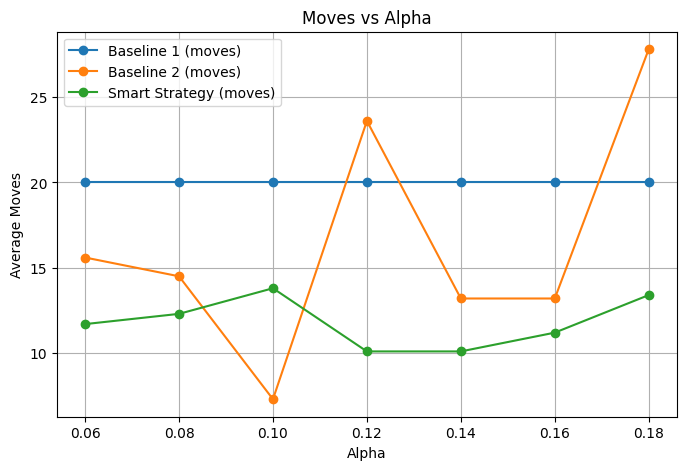

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(alpha_values, baseline_moves_1, marker='o', label='Baseline 1 (moves)')
plt.plot(alpha_values, baseline_moves_2, marker='o', label='Baseline 2 (moves)')
plt.plot(alpha_values, smart_moves, marker='o', label='Smart Strategy (moves)')

plt.xlabel('Alpha')
plt.ylabel('Average Moves')
plt.title('Moves vs Alpha')
plt.grid(True)
plt.legend()
plt.show()

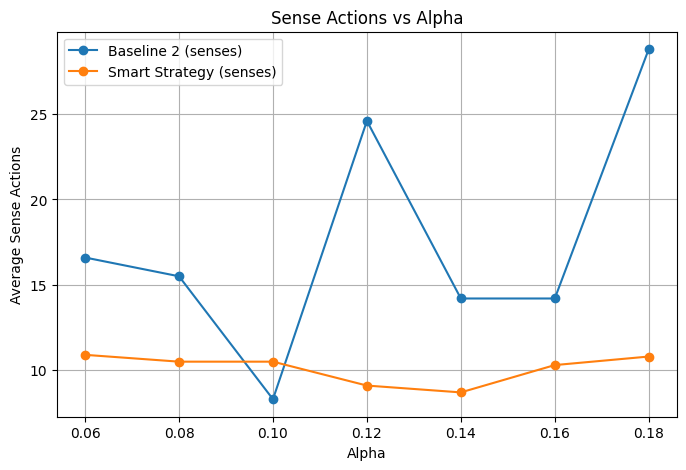

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(alpha_values, baseline_senses_2, marker='o', label='Baseline 2 (senses)')
plt.plot(alpha_values, smart_senses, marker='o', label='Smart Strategy (senses)')

plt.xlabel('Alpha')
plt.ylabel('Average Sense Actions')
plt.title('Sense Actions vs Alpha')
plt.grid(True)
plt.legend()
plt.show()

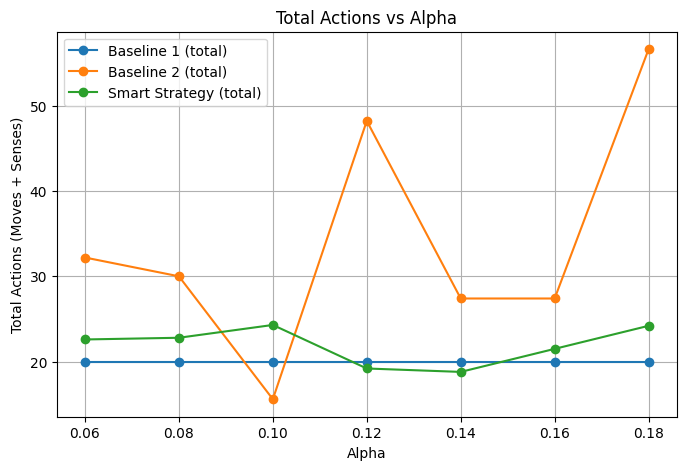

In [ ]:
baseline_total_2 = [baseline_moves_2[i] + baseline_senses_2[i] for i in range(len(alpha_values))]
smart_total = [smart_moves[i] + smart_senses[i] for i in range(len(alpha_values))]

plt.figure(figsize=(8,5))
plt.plot(alpha_values, baseline_moves_1, marker='o', label='Baseline 1 (total)')
plt.plot(alpha_values, baseline_total_2, marker='o', label='Baseline 2 (total)')
plt.plot(alpha_values, smart_total, marker='o', label='Smart Strategy (total)')

plt.xlabel('Alpha')
plt.ylabel('Total Actions (Moves + Senses)')
plt.title('Total Actions vs Alpha')
plt.grid(True)
plt.legend()
plt.show()

# Task 5- 4th Strategy

In [ ]:
def fourth_strategy(ship, locator_pos, alpha, roomba_pos, dist_from_to, max_steps=1000, conf_threshold=0.99):
    belief = initialize_belief(ship)
    move_count = 0
    sense_count = 0
    actions = ['SENSE', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'L-UP', 'L-DOWN', 'L-LEFT', 'L-RIGHT']
    DIST_WEIGHT = alpha * 2  # Favor dist reduction more for low alpha
    TERM_REWARD = 10.0       # Favor termination

    # graph distance from locator to belief weighted roomba position
    def get_expected_dist(belief, locator):
        return sum(p * dist_from_to.get((locator, cell), 0) for cell, p in belief.items())

    for step in range(max_steps):
        if max(belief.values(), default=0) >= conf_threshold or locator_pos == roomba_pos:
            return move_count, sense_count
        current_H = entropy(belief)
        current_exp_dist = get_expected_dist(belief, locator_pos)
        best_action = None
        best_score = -float('inf')

        # Evaluating each action with 1 step lookahead
        for action in actions:
            exp_max_prob = 0.0
            exp_dist_after = current_exp_dist
            score = 0.0

            if action == 'SENSE':
                prob_beep = sum(p * min(1, math.exp(-alpha * (dist_from_to.get((locator_pos, cell), float('inf')) - 1))) for cell, p in belief.items())
                b_beep = update_belief_after_sense(copy.deepcopy(belief), locator_pos, True, alpha)
                H_beep = entropy(b_beep)
                b_nobeep = update_belief_after_sense(copy.deepcopy(belief), locator_pos, False, alpha)
                H_nobeep = entropy(b_nobeep)
                exp_H = prob_beep * H_beep + (1 - prob_beep) * H_nobeep
                exp_max_prob = prob_beep * max(b_beep.values(), default=0) + (1 - prob_beep) * max(b_nobeep.values(), default=0)
                score = current_H - exp_H

            # Locator Move
            elif action.startswith('L-'):
                move_dir = action[2:]
                new_loc = sense_move(locator_pos, ship, move_dir)
                if new_loc == locator_pos:
                    continue
                prob_at = belief.get(new_loc, 0.0)
                if (1 - prob_at) > 0:
                    new_belief = {c:p/(1-prob_at) for c,p in belief.items() if c!=new_loc}
                    H_not = entropy(new_belief)
                    exp_H = (1-prob_at)*H_not
                    score = current_H - exp_H
                    exp_dist_after = get_expected_dist(new_belief, new_loc)
                    exp_max_prob = prob_at + (1 - prob_at) * max(new_belief.values(), default=0)
                else:
                    score = -float('inf')

            # Roomba move
            else:
                temp = update_belief_after_move(copy.deepcopy(belief), ship, action)
                prob_coll = temp.get(locator_pos, 0.0)
                if (1 - prob_coll) > 0:
                    new_b = {c:p/(1-prob_coll) for c,p in temp.items() if c!=locator_pos}
                    Hn = entropy(new_b)
                    exp_H = (1-prob_coll)*Hn
                    score = current_H - exp_H
                    exp_dist_after = get_expected_dist(new_b, locator_pos)
                    exp_max_prob = prob_coll + (1 - prob_coll) * max(new_b.values(), default=0)
                else:
                    score = -float('inf')

            # Add weighted dist reduction and termination to score
            dist_red = current_exp_dist - exp_dist_after
            score += DIST_WEIGHT * dist_red + TERM_REWARD * exp_max_prob

            if score > best_score:
                best_score = score
                best_action = action

        if best_action is None:
            break

        # Execute chosen action
        if best_action == 'SENSE':
            beep = run_detector(roomba_pos, locator_pos, alpha)
            belief = update_belief_after_sense(belief, locator_pos, beep, alpha)
            sense_count += 1
            continue

        # Locator move
        if best_action.startswith('L-'):
            move_dir = best_action[2:]
            new_loc = sense_move(locator_pos, ship, move_dir)
            locator_pos = new_loc
            move_count += 1
            if new_loc in belief:
                p_at = belief[new_loc]
                del belief[new_loc]
                if (1 - p_at) > 0:
                    for c in belief:
                        belief[c] /= (1 - p_at)
            continue

        # Roomba move: Update true pos and belief
        roomba_pos = sense_move(roomba_pos, ship, best_action)
        belief = update_belief_after_move(belief, ship, best_action)
        move_count += 1

        # If no collision, remove mass from locator_pos and renormalize
        if locator_pos in belief:
            p_col = belief[locator_pos]
            del belief[locator_pos]
            if (1 - p_col) > 0:
                for c in belief:
                    belief[c] /= (1 - p_col)

    return move_count, sense_count

In [ ]:
np.random.seed(42)
random.seed(42)

alpha_values = [0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18]
f_moves = []
f_actions = []
num_samples = 10

ship = ship_generator(D=10, loop_chance=0.5, seed=42)
dist_from_to = precompute_distances(ship)

open_cells = [(i, j) for i in range(ship.shape[0]) for j in range(ship.shape[1]) if ship[i, j] == 0]
h, w = ship.shape
locator_pos = (h // 2, w // 2)
roomba_pos = random.choice(open_cells)

for alpha in alpha_values:
  f_moves_total = 0
  f_senses_total = 0

  for _ in range(num_samples):
    m, s = fourth_strategy(ship, locator_pos, alpha, roomba_pos, dist_from_to)
    f_moves_total += m
    f_senses_total += s

  f_moves.append(f_moves_total / num_samples)
  f_actions.append(f_senses_total / num_samples)

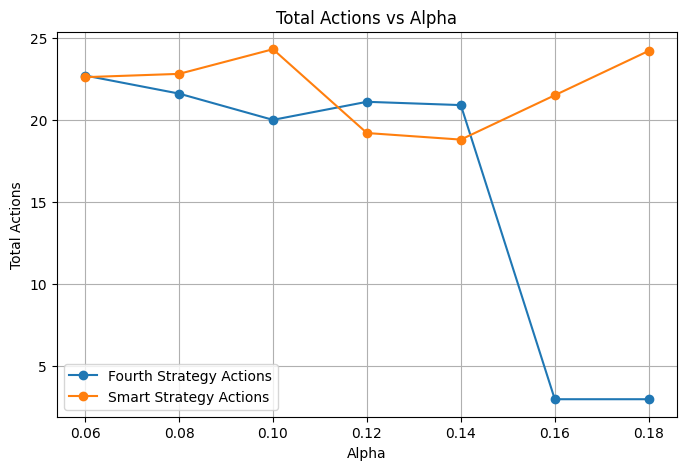

In [ ]:
fourth_strategy_total = [f_moves[i] + f_actions[i] for i in range(len(alpha_values))]
smart_total = [smart_moves[i] + smart_senses[i] for i in range(len(alpha_values))]

plt.figure(figsize=(8,5))
plt.plot(alpha_values, fourth_strategy_total, marker='o', label='Fourth Strategy Actions')
plt.plot(alpha_values, smart_total, marker='o', label='Smart Strategy Actions')

plt.xlabel('Alpha')
plt.ylabel('Total Actions')
plt.title('Total Actions vs Alpha')
plt.grid(True)
plt.legend()
plt.show()